## 1. Data
### `AtomsGraph`

- `AtomsGraph` is a graph-based data structure that contains structural information and (possibly) some properties(ex. energy, force, stress, ...)
- Basically a `pytorch_geometric.data.Data` with some extended functionalities (see ![here](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html) for tutorial of `Data`)
- Can be batched to store multiple structures

In [1]:
# Example: water molecule
import aml
import ase.build
from ase.visualize.plot import plot_atoms

atoms = ase.build.molecule("H2O")  # create water molecule
print("Species:", atoms.get_chemical_symbols())  # print species of atoms
print("Positions:\n", atoms.get_positions())  # print positions of atoms

Species: ['O', 'H', 'H']
Positions:
 [[ 0.        0.        0.119262]
 [ 0.        0.763239 -0.477047]
 [ 0.       -0.763239 -0.477047]]


In [2]:
import torch

# Direct creation
data = aml.data.AtomsGraph(
    elems=torch.as_tensor(atoms.get_atomic_numbers(), dtype=torch.long),
    pos=torch.as_tensor(atoms.get_positions(), dtype=torch.float32),
    # Optional: cell for periodic systems
    cell=torch.as_tensor(atoms.get_cell().array, dtype=torch.float32).view(-1, 3, 3),  # (1, 3, 3)
)
print("Data:", data)
print("Species:", data.elems)
print("Positions:\n", data.pos)

Data: AtomsGraph(elems=[3], pos=[3, 3], cell=[1, 3, 3])
Species: tensor([8, 1, 1])
Positions:
 tensor([[ 0.0000,  0.0000,  0.1193],
        [ 0.0000,  0.7632, -0.4770],
        [ 0.0000, -0.7632, -0.4770]])


In [3]:
# Creation from atoms - automatically add some attributes

data = aml.data.AtomsGraph.from_ase(atoms)
print("Data:", data)
print("Species:", data.elems)
print("Positions:\n", data.pos)
print("Number of atoms:", data.n_atoms)
print("Batch:", data.batch)  # batch index


Data: AtomsGraph(elems=[3], pos=[3, 3], cell=[1, 3, 3], n_atoms=[1], batch=[3])
Species: tensor([8, 1, 1])
Positions:
 tensor([[ 0.0000,  0.0000,  0.1193],
        [ 0.0000,  0.7632, -0.4770],
        [ 0.0000, -0.7632, -0.4770]])
Number of atoms: tensor([3])
Batch: tensor([0, 0, 0])


In [4]:
# Creation from atoms + building neighborlist
data = aml.data.AtomsGraph.from_ase(atoms, neighborlist_cutoff=5.0)
print("Edges(neighbors) connecting indices:\n", data.edge_index)  # (2, N) <-> (idx_j, idx_i)
print("Shift vectors:\n", data.edge_shift) # Neccessary when structure is periodic


Edges(neighbors) connecting indices:
 tensor([[1, 2, 0, 2, 0, 1],
        [0, 0, 1, 1, 2, 2]])
Shift vectors:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [5]:
atoms = data.to_ase() # returns an ASE Atoms object
atoms

Atoms(symbols='OH2', pbc=False)

## 2. Dataset

- `aml.data.ASEDataset` creates dataset from ASE readable files
- Example: `water_train.traj` has 1,000 conformer structures of H<sub>2</sub>O molecule sampled from AIMD
- `ASEDataset` will construct a dataset that contains 1,000 `AtomsGraph`

In [6]:
dataset = aml.data.ASEDataset(
    data_source=["../data/water_train.xyz"],
    index=[":"],
    neighborlist_cutoff=5.0,
    neighborlist_backend="ase", # or faster "matscipy"
)
print(dataset)
print("Example data: ", dataset[0])

154it [00:00, 782.70it/s]

1000it [00:01, 894.72it/s]

ASEDataset(1000)
Example data:  AtomsGraph(elems=[3], pos=[3, 3], cell=[1, 3, 3], energy=[1], force=[3, 3], n_atoms=[1], batch=[3], edge_index=[2, 6], edge_shift=[6, 3])


In [7]:
# Save & load
dataset.save("water_dataset.pt")
dataset = dataset.load("water_dataset.pt")

In [8]:
# Split
train_dataset, val_dataset = dataset.split(900, seed=0)
print(f"Number of training structures: {len(train_dataset)}")
print(f"Number of validation structures: {len(val_dataset)}")


Number of training structures: 900
Number of validation structures: 100


In [9]:
# Make dataloader
from torch_geometric.loader import DataLoader

loader = DataLoader(dataset, batch_size=4, shuffle=True)
# example batch
for batch in loader:
    print(batch)
    break
print(batch.pos, batch.batch)

AtomsGraphBatch(elems=[12], pos=[12, 3], cell=[4, 3, 3], energy=[4], force=[12, 3], n_atoms=[4], batch=[12], edge_index=[2, 24], edge_shift=[24, 3], ptr=[5])
tensor([[ 0.2548, -0.4426, -0.1686],
        [ 0.4453,  0.4462, -0.4843],
        [-0.4453, -0.4462,  0.4843],
        [ 0.3970,  0.1561,  0.3008],
        [ 0.2718,  0.2553, -0.6489],
        [-0.3970, -0.2553,  0.6489],
        [ 0.0423, -0.3154,  0.2558],
        [-0.7262, -0.0854, -0.2558],
        [ 0.7262,  0.3154, -0.0038],
        [ 0.3975, -0.2622,  0.2705],
        [ 0.5450,  0.4885, -0.2891],
        [-0.5450, -0.4885,  0.2891]]) tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])


## 3. InterAtomicPotential

- `aml.models.InterAtomicPotential` is generic base class for interatomic potential(IAP) models
- To define `InterAtomicPotential` the needed arguments:
  - `energy_model` (`BaseEnergyModel`): the `torch.nn.Module` that computes energy when `AtomsGraph` is given
  - `compute_force`, `compute_stress`, `compute_hessian`: whether to compute these properties or not. Only `compute_force` is `True` by default.
  - `return_embeddings`: Return learned (or fixed) embeddings from `energy_model`.
- See `aml.models.energy_models` for all available models and their configurations.

In [10]:
# Example: SchNet model for H2O
from aml.models.energy_models import SchNet, BaseEnergyModel

energy_model = SchNet(
    # These are common parameters for all energy models
    species=["H", "O"],
    cutoff=5.0,
    # These are specific parameters for SchNet
    hidden_channels=128,
    n_filters=128,
    n_interactions=6,
    rbf_type="gaussian",
    n_rbf=50,
    trainable_rbf=False,
)

# Or from config dict
config = {
    "species": ["H", "O"],
    "cutoff": 5.0,
    "hidden_channels": 128,
    "n_filters": 128,
    "n_interactions": 6,
    "rbf_type": "gaussian",
    "n_rbf": 50,
    "trainable_rbf": False,
}
energy_model = SchNet.from_config(config)

# Alternatively, specify model name in config dict
config = {
    "@name": "schnet",
    "species": ["H", "O"],
    "cutoff": 5.0,
    "hidden_channels": 128,
    "n_filters": 128,
    "n_interactions": 6,
    "rbf_type": "gaussian",
    "n_rbf": 50,
    "trainable_rbf": False,
}
energy_model = BaseEnergyModel.from_config(config)

In [11]:
# Demonstration
energy = energy_model(data)
print("Energy:", energy)

# Works for batched data too
batch = next(iter(loader))
batch.compute_edge_vecs()
energies = energy_model(batch)
print("Energies:", energies)

Energy: tensor([-2.1537], grad_fn=<ScatterAddBackward0>)
Energies: tensor([-2.1571, -2.1790, -2.1669, -2.1678], grad_fn=<ScatterAddBackward0>)


In [12]:
# Define interatomic potential

model = aml.models.InterAtomicPotential(
    energy_model=energy_model,
    compute_force=True,
    compute_stress=False,
    compute_hessian=False,
    return_embeddings=False,
)
output = model(data)
for key in output:
    print(key, ":", output[key].shape)

# compute hessian
model.compute_hessian = True
output = model(data)
print()
for key in output:
    print(key, ":", output[key].shape)

# return embeddings
model.return_embeddings = True
output = model(data)
print()
for key in output:
    print(key, ":", output[key].shape)

energy : torch.Size([1])
force : torch.Size([3, 3])

energy : torch.Size([1])
force : torch.Size([3, 3])
hessian : torch.Size([9, 9])

energy : torch.Size([1])
force : torch.Size([3, 3])
hessian : torch.Size([9, 9])
node_features : torch.Size([3, 128])


## Excercise - very simple training loop

- Let's go through one epoch of training
- Loss: `0.01 * energy MSE + 1.00 * force MSE`
- Use `Adam` optimizer
- Before training we can fit the energy scales to model by `energy_model.initialize()`

In [13]:
import torch
from torch.nn import functional as F

# Model setup
model.compute_force = True
model.compute_stress = False
model.compute_hessian = False
model.return_embeddings = False
model.energy_model.initialize(dataset=train_dataset) # set the mean and std of the energy model

def compute_loss_and_output(model, data):
    output = model(data)
    energy_mse = F.mse_loss(output["energy"], data["energy"])
    force_mse = F.mse_loss(output["force"], data["force"])
    loss = 0.01 * energy_mse + 1.00 * force_mse
    return loss, output


def compute_metrics(output, data):
    energy_mae = F.l1_loss(output["energy"], data["energy"])
    force_mae = F.l1_loss(output["force"], data["force"])
    return energy_mae, force_mae

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("===== Training =====")
for i, train_batch in enumerate(train_loader):
    model.train()
    optimizer.zero_grad()
    loss, output = compute_loss_and_output(model, train_batch)
    loss.backward()
    optimizer.step()
    if i % 25 == 0:
        energy_mae, force_mae = compute_metrics(output, train_batch)
        print(f"Batch {i}: train loss {loss.item():.3f} energy mae {energy_mae.item():.3f} force mae {force_mae.item():.3f}")

print("===== Validating =====")
for i, val_batch in enumerate(val_loader):
    model.eval()
    loss, output = compute_loss_and_output(model, val_batch)
    energy_mae, force_mae = compute_metrics(output, val_batch)
    print(f"Batch {i}: val loss {loss.item():.3f} energy mae {energy_mae.item():.3f} force mae {force_mae.item():.3f}")

===== Training =====
Batch 0: train loss 0.206 energy mae 0.970 force mae 0.318
Batch 25: train loss 0.095 energy mae 0.010 force mae 0.263
Batch 50: train loss 0.016 energy mae 0.262 force mae 0.093
Batch 75: train loss 0.006 energy mae 0.137 force mae 0.061
Batch 100: train loss 0.003 energy mae 0.025 force mae 0.046
Batch 125: train loss 0.013 energy mae 0.045 force mae 0.081
Batch 150: train loss 0.003 energy mae 0.026 force mae 0.035
Batch 175: train loss 0.031 energy mae 0.009 force mae 0.105
Batch 200: train loss 0.012 energy mae 0.017 force mae 0.091
===== Validating =====
Batch 0: val loss 0.022 energy mae 0.022 force mae 0.111
Batch 1: val loss 0.019 energy mae 0.023 force mae 0.112
Batch 2: val loss 0.018 energy mae 0.024 force mae 0.103
Batch 3: val loss 0.008 energy mae 0.022 force mae 0.065
Batch 4: val loss 0.024 energy mae 0.024 force mae 0.114
Batch 5: val loss 0.018 energy mae 0.024 force mae 0.114
Batch 6: val loss 0.010 energy mae 0.025 force mae 0.083
Batch 7: val 

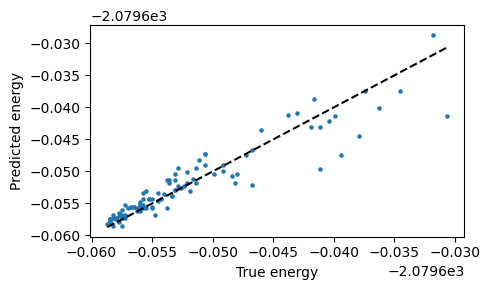

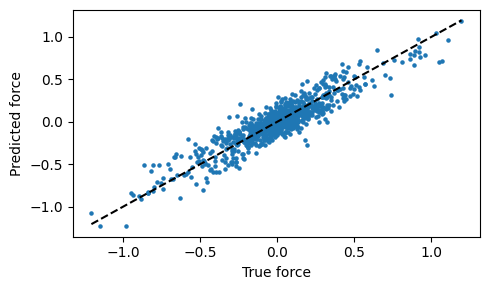

In [14]:
# Draw parity plots
import numpy as np
import matplotlib.pyplot as plt

def parity_plot(true, pred, name="energy"):
    plt.figure(figsize=(5, 3))
    plt.scatter(true, pred, s=5)
    plt.plot([np.min(true), np.max(true)], [np.min(true), np.max(true)], "k--")
    plt.xlabel(f"True {name}")
    plt.ylabel(f"Predicted {name}")
    plt.tight_layout()
    plt.show()

energy_true = []
energy_pred = []
force_true = []
force_pred = []

for batch in val_loader:
    output = model(batch)
    energy_true.append(batch["energy"].detach().cpu().numpy().squeeze())
    energy_pred.append(output["energy"].detach().cpu().numpy().squeeze())
    force_true.append(batch["force"].detach().cpu().numpy())
    force_pred.append(output["force"].detach().cpu().numpy())

energy_true = np.concatenate(energy_true)
energy_pred = np.concatenate(energy_pred)
energy_pred -= np.mean(energy_pred - energy_true) # align the constant shift of energy
force_true = np.concatenate(force_true).ravel()
force_pred = np.concatenate(force_pred).ravel()

parity_plot(energy_true, energy_pred, name="energy")
parity_plot(force_true, force_pred, name="force")
